# Regression trainner (make sure mask and the beads matches)

## Cluster function

In [1]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import sys
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import time

# Ensure the notebook can import the custom U-Net module
cwd = os.getcwd()
custom_unet_dir = os.path.join(cwd, "src", "soil_segment")
if not os.path.exists(os.path.join(custom_unet_dir, "custom_unet.py")):
    custom_unet_dir = os.path.join(os.path.dirname(cwd), "src", "soil_segment")
if os.path.exists(os.path.join(custom_unet_dir, "custom_unet.py")) and custom_unet_dir not in sys.path:
    sys.path.insert(0, custom_unet_dir)
PROJECT_ROOT = Path(custom_unet_dir).resolve().parent.parent
DEFAULT_REGRESSOR_DATASET_DIR = str(PROJECT_ROOT / "datasets" / "regressor_dataset")


# Resolve checkpoints directory relative to current working directory
def resolve_checkpoint_path(filename="best_model.pth"):
    search_dir = cwd
    while True:
        candidate = os.path.join(search_dir, "checkpoints", filename)
        if os.path.exists(candidate):
            return candidate
        parent = os.path.dirname(search_dir)
        if parent == search_dir:
            break
        search_dir = parent
    raise FileNotFoundError(f"Checkpoint '{filename}' not found relative to {cwd}")


# Import your custom U-Net
from custom_unet import SimpleUNet, ConvBlock

# === FILTER CONFIG ===
BEAD_MASKS = 4             # Number of clusters/classes (excluding background)
CONTRAST_FACTOR = 1       # >1 increases contrast
SATURATION_FACTOR = 1       # >1 increases vividity
BRIGHTNESS_OFFSET = 0      # Offset for brightness adjustment
NUM_CLASSES = None         # Will be inferred from checkpoint

# Check GPU availability
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# === Load U-Net Model ===
def load_unet_model():
    """Load the trained U-Net model and infer its number of classes."""
    checkpoint_path = resolve_checkpoint_path("best_model.pth")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    state_dict = checkpoint.get('model_state_dict', checkpoint)

    if 'final_conv.weight' not in state_dict:
        raise KeyError("Checkpoint is missing 'final_conv.weight'; cannot infer number of classes.")

    num_classes = state_dict['final_conv.weight'].shape[0]
    model = SimpleUNet(in_channels=3, n_classes=num_classes)
    model.load_state_dict(state_dict)
    model.eval()
    model.to(DEVICE)

    global NUM_CLASSES
    NUM_CLASSES = num_classes
    print(f"Loaded U-Net with {NUM_CLASSES} classes.")
    return model
# Initialize model
unet_model = load_unet_model()

# U-Net preprocessing transform
unet_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # must match training size
    transforms.ToTensor(),          # Converts to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # same normalization as training
])

# === Auto-detect image folders ===
def auto_detect_image_folders(base_path=DEFAULT_REGRESSOR_DATASET_DIR):
    """
    Automatically detect all subfolders in the base path that contain images
    
    Args:
        base_path (str or Path): Base directory to search for image folders
    
    Returns:
        list: List of lists containing image paths for each folder
    """
    img_path_list = []

    base_path = Path(base_path)
    candidate_paths = []
    seen = set()

    def _register_candidate(path_candidate):
        path_candidate = Path(path_candidate)
        key = path_candidate.resolve() if path_candidate.exists() else path_candidate
        if key in seen:
            return
        seen.add(key)
        candidate_paths.append(path_candidate)

    _register_candidate(base_path)

    if not base_path.is_absolute():
        _register_candidate(Path(cwd) / base_path)
        _register_candidate(PROJECT_ROOT / base_path)
        _register_candidate(PROJECT_ROOT / "datasets" / base_path)
    else:
        _register_candidate(Path(cwd) / base_path.name)
        _register_candidate(PROJECT_ROOT / base_path.name)
        _register_candidate(PROJECT_ROOT / "datasets" / base_path.name)

    _register_candidate(PROJECT_ROOT / "datasets" / "regressor_dataset")

    resolved_base = None
    for candidate in candidate_paths:
        candidate = candidate.expanduser()
        if candidate.exists():
            resolved_base = candidate.resolve()
            break

    if resolved_base is None:
        pretty = base_path if base_path.is_absolute() else base_path.as_posix()
        print(f"Warning: Base path '{pretty}' not found in any known location.")
        return img_path_list

    if not resolved_base.is_dir():
        print(f"Warning: Resolved path '{resolved_base}' is not a directory.")
        return img_path_list

    print(f"Using dataset directory: {resolved_base}")

    subdirs = [p for p in sorted(resolved_base.iterdir()) if p.is_dir()]

    print(f"Found {len(subdirs)} subdirectories in '{resolved_base.name}':")

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

    for subdir in subdirs:
        image_files = [p for p in sorted(subdir.iterdir()) if p.suffix.lower() in image_extensions]

        if image_files:
            image_paths = [str(p) for p in image_files]
            img_path_list.append(image_paths)
            print(f"  ✓ {subdir.name}: {len(image_files)} images")
        else:
            print(f"  ✗ {subdir.name}: No images found")

    if not img_path_list:
        print("No valid image folders found.")
    else:
        print(f"
Total folders with images: {len(img_path_list)}")

    return img_path_list
# === Load the image paths automatically ===
img_path_list = auto_detect_image_folders("regressor_dataset")

if not img_path_list:
    raise FileNotFoundError("No valid image folders found.")

# === Load image to rgb ===
def load_img_as_rgb(img_path):
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found at: {img_path}")
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === U-Net prediction function ===
def predict_with_unet(image_path, model):
    """
    Use U-Net to predict segmentation masks instead of K-means clustering
    
    Args:
        image_path (str): Path to the input image
        model: Trained U-Net model
    
    Returns:
        numpy.ndarray: Predicted segmentation mask
        numpy.ndarray: Enhanced image for visualization
    """
    # Load and enhance the image
    rgb_image = load_img_as_rgb(image_path)
    
    # Convert enhanced image to PIL for U-Net preprocessing
    enhanced_pil = Image.fromarray(rgb_image.astype(np.uint8))
    
    # Preprocess for U-Net
    input_tensor = unet_transform(enhanced_pil).unsqueeze(0).to(DEVICE)
    
    # Get U-Net prediction
    with torch.no_grad():
        output = model(input_tensor)  # Shape: [1, num_classes, H, W]
    
    # Get predicted mask
    if output.shape[1] == 1:
        # Binary segmentation
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
    else:
        # Multi-class segmentation
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # Resize prediction back to original image size
    original_size = rgb_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), 
                                  (original_size[1], original_size[0]), 
                                  interpolation=cv2.INTER_NEAREST)
    
    return pred_mask_resized, rgb_image

# === GPU-accelerated clustering replacement with U-Net ===
def get_cluster_mask_gpu(image_path, use_gpu=True):
    """
    Replace K-means clustering with U-Net prediction.
    Returns masks in order of U-Net class IDs (1 to BEAD_MASKS).
    """
    if not use_gpu or not torch.cuda.is_available():
        raise NotImplementedError("GPU acceleration is required for this function.")
    
    # Get U-Net prediction
    pred_mask, enhanced_image = predict_with_unet(image_path, unet_model)
    
    H, W = pred_mask.shape

    # Create individual masks for each class (excluding background class 0)
    all_masks = []
    for class_id in range(1, min(NUM_CLASSES, BEAD_MASKS + 1)):
        class_mask = (pred_mask == class_id)
        all_masks.append(class_mask)
    
    # If fewer classes are present, pad with empty masks
    while len(all_masks) < BEAD_MASKS:
        all_masks.append(np.zeros((H, W), dtype=bool))
    
    # Only keep the first BEAD_MASKS classes (in U-Net ID order)
    all_masks = all_masks[:BEAD_MASKS]
    
    return all_masks, enhanced_image

# === GPU-accelerated area computation ===
def get_area_gpu(image_path, use_gpu=True):
    all_masks, enhanced_image = get_cluster_mask_gpu(image_path, use_gpu)
    
    # Compute cluster areas
    cluster_areas = []
    if use_gpu and torch.cuda.is_available():
        for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
            mask_tensor = torch.from_numpy(mask).to(DEVICE)
            area = int(torch.sum(mask_tensor > 0).item())
            cluster_areas.append(area)
    else:
        for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
            area = np.sum(mask > 0)
            cluster_areas.append(area)

    return cluster_areas, all_masks, enhanced_image

# === Process all images and return numpy array ===
def process_all_images(use_gpu=True):
    """
    Process all images in img_path_list and return cluster areas as numpy array of shape (n_images, 4)
    
    Args:
        use_gpu (bool): Whether to use GPU acceleration
    
    Returns:
        numpy.ndarray: Array of shape (n_images, 4) containing cluster areas for each image
    """
    all_results = []
    total_images = sum(len(folder_images) for folder_images in img_path_list)
    
    print(f"Processing {total_images} images using {'GPU U-Net' if use_gpu and torch.cuda.is_available() else 'CPU'}")
    print("="*60)
    
    image_counter = 0
    
    for folder_idx, folder_images in enumerate(img_path_list):
        folder_name = f"Folder {folder_idx + 1}"
        print(f"\n{folder_name}: Processing {len(folder_images)} images")
        print("-" * 40)
        
        for img_idx, img_path in enumerate(folder_images):
            image_counter += 1
            # print(f"\n[{image_counter}/{total_images}] Processing: {os.path.basename(img_path)}")
            
            try:
                start_time = time.time()
                
                # Get cluster areas for this image using U-Net
                cluster_areas, _, _ = get_area_gpu(img_path, use_gpu)
                
                # Ensure we have exactly 4 clusters
                if len(cluster_areas) != BEAD_MASKS:
                    print(f"Warning: Expected {BEAD_MASKS} clusters, got {len(cluster_areas)}")
                    # Pad with zeros if needed, or truncate if too many
                    padded_areas = np.zeros(BEAD_MASKS)
                    padded_areas[:min(len(cluster_areas), BEAD_MASKS)] = cluster_areas[:BEAD_MASKS]
                    cluster_areas = padded_areas
                
                all_results.append(cluster_areas)
                
                end_time = time.time()
                # Uncomment the next line to print completion time for each image
                # print(f"✓ Completed in {end_time - start_time:.2f} seconds")
                
            except Exception as e:
                print(f"✗ Error processing {img_path}: {str(e)}")
                # Add zeros for failed images to maintain array structure
                all_results.append(np.zeros(BEAD_MASKS))
    
    # Convert to numpy array
    results_array = np.array(all_results)
    
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total images processed: {len(results_array)}")
    print(f"Results shape: {results_array.shape}")
    print(f"Data type: {results_array.dtype}")
    
    return results_array

Using device: cuda
Found 3 subdirectories in 'regressor_dataset':
  ✓ 15-15-15: 23 images
  ✓ 15-4-20: 23 images
  ✓ 18-4-5: 23 images

Total folders with images: 3
Total images found: 69


## Visualization

Processing example image: regressor_dataset\15-15-15\IMG_0863.JPG


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 215.88it/s]


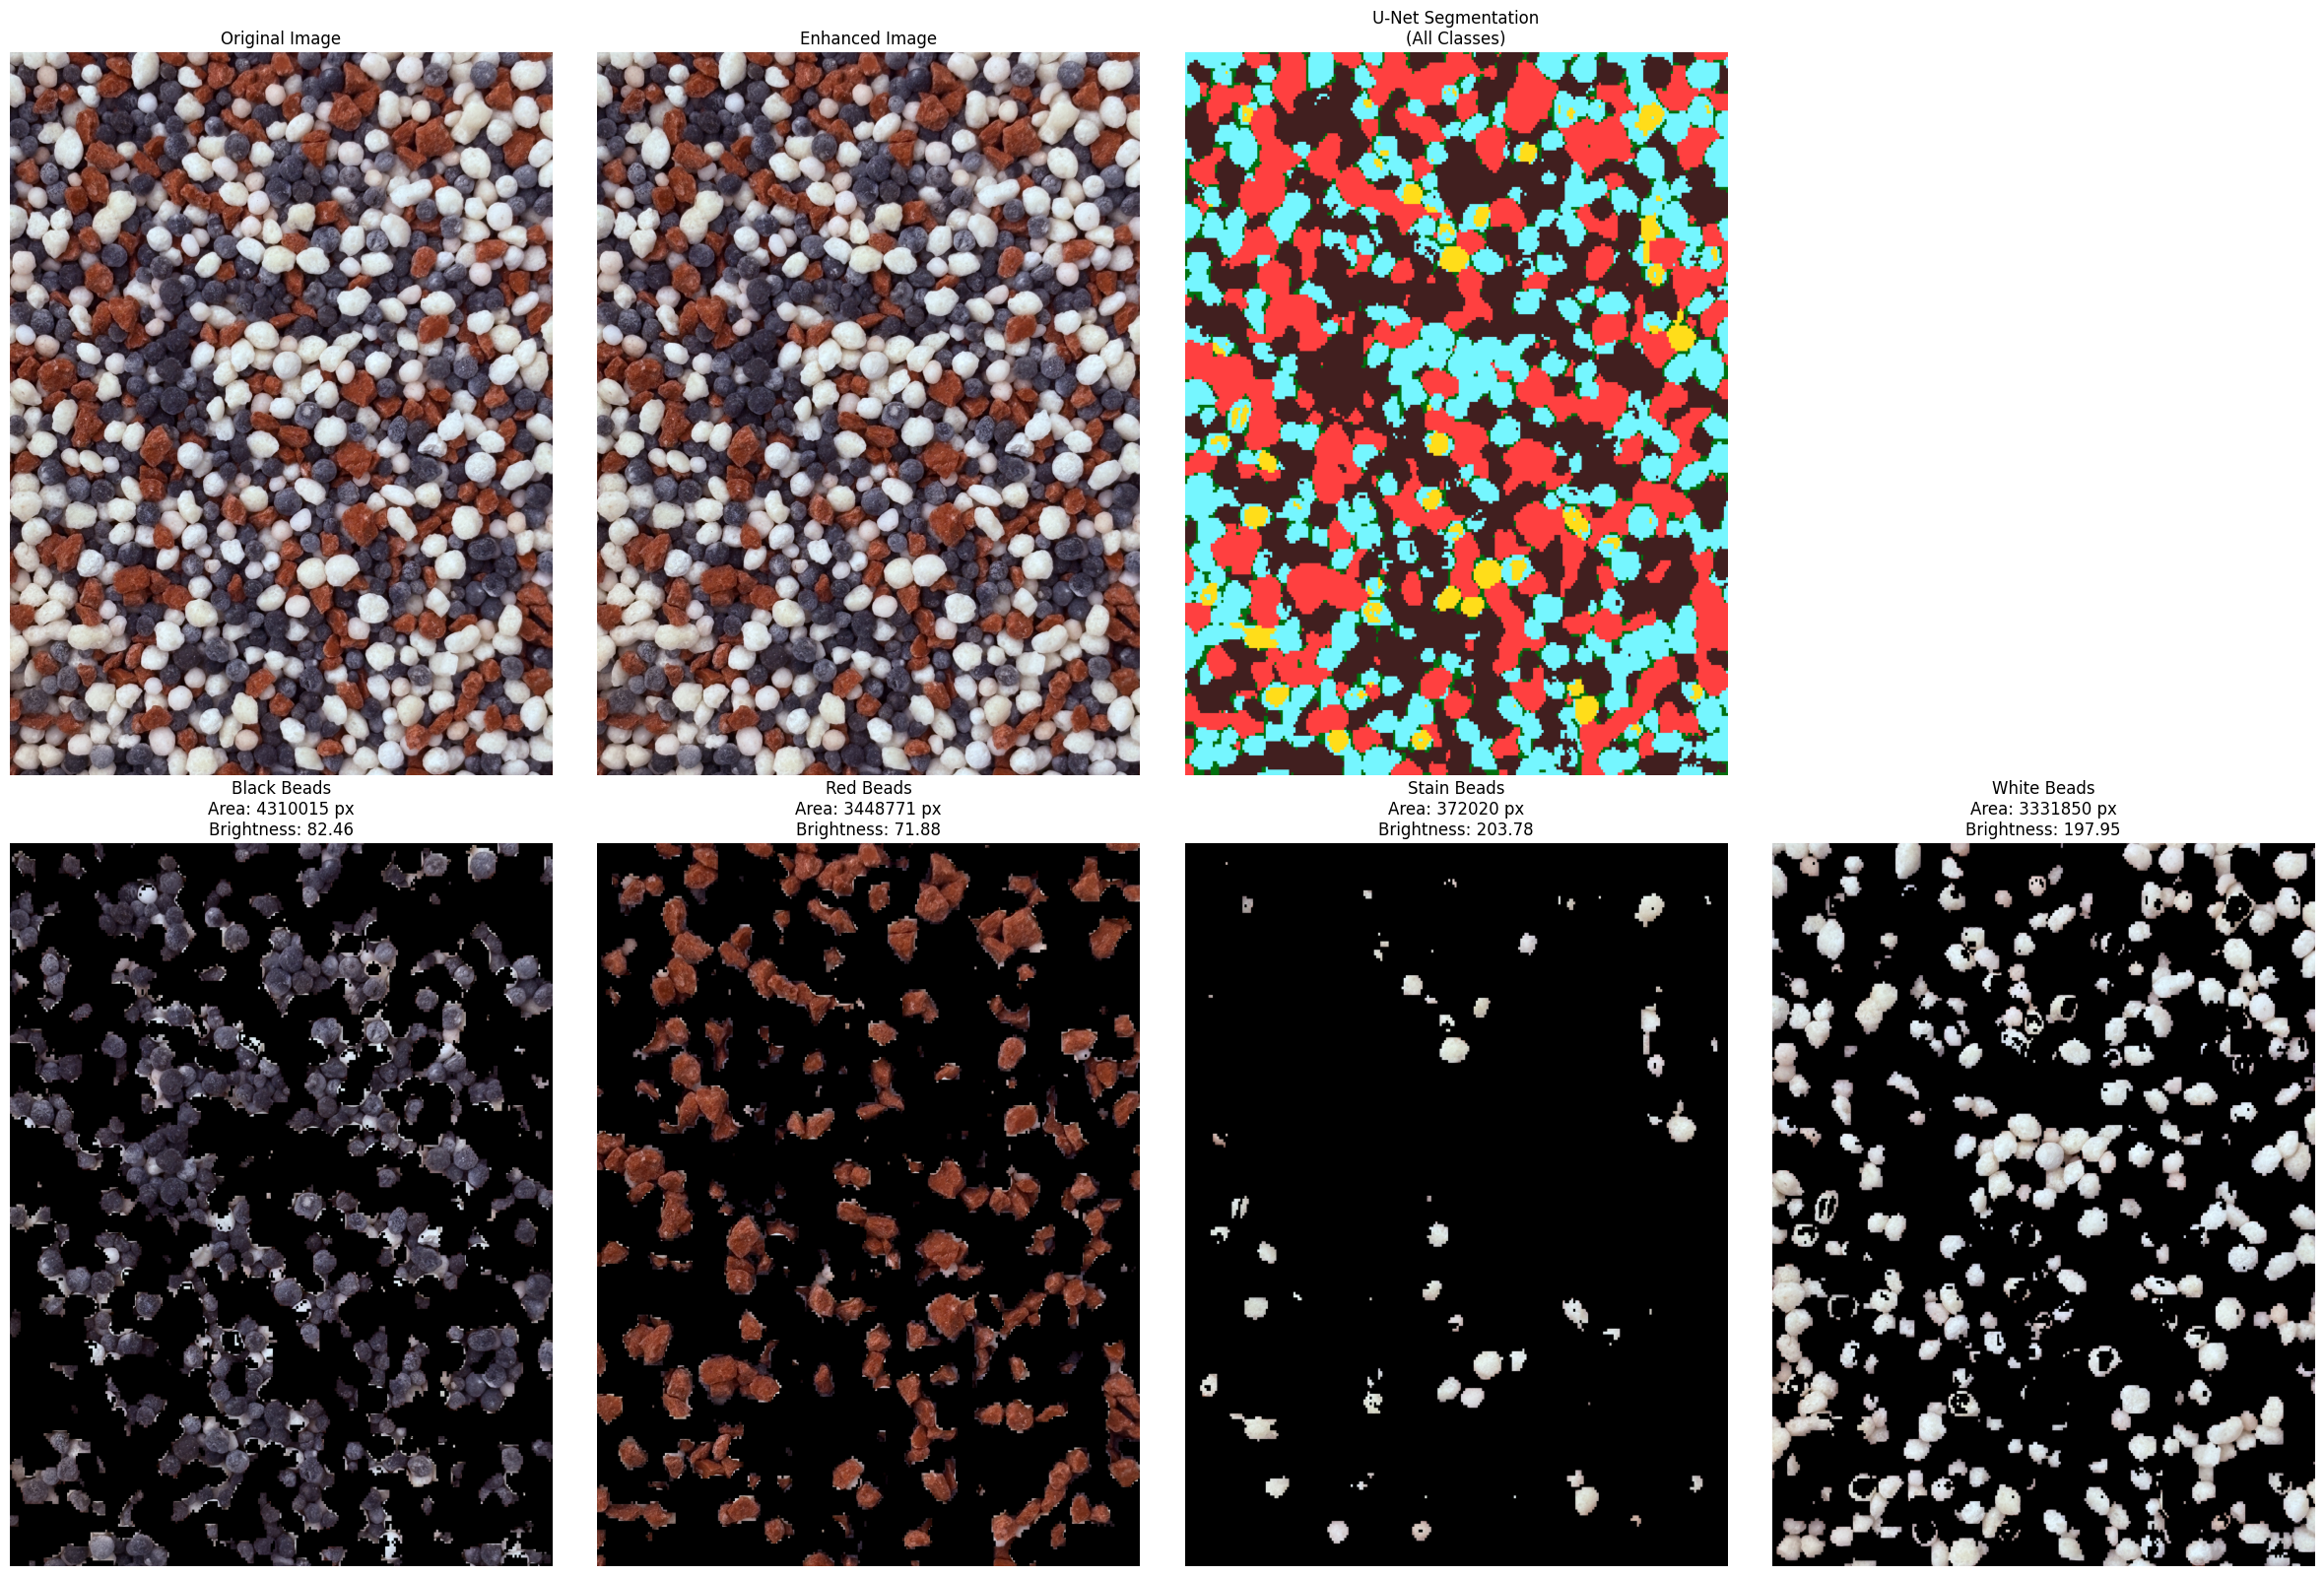


U-Net Prediction Statistics:
----------------------------------------
Background: 730112 pixels
Class 1 (Black Beads): 4310015 pixels
Class 2 (Red Beads): 3448771 pixels
Class 3 (Stain Beads): 372020 pixels
Class 4 (White Beads): 3331850 pixels

U-Net Cluster Statistics:
------------------------------
Black Beads: 4310015 pixels
Red Beads: 3448771 pixels
Stain Beads: 372020 pixels
White Beads: 3331850 pixels

Processing all images to get cluster areas...


In [2]:
# === Visualize example image with enhancements and U-Net predictions ===
example_img_path = img_path_list[0][0]  # First image from first folder
image_rgb = load_img_as_rgb(example_img_path)

print(f"Processing example image: {example_img_path}")

# Get U-Net prediction and enhanced image
pred_mask, rgb_image = predict_with_unet(example_img_path, unet_model)
cluster_areas, all_masks, _ = get_area_gpu(example_img_path, use_gpu=True)

# Create visualization
plt.figure(figsize=(24, 16))

# Original image
plt.subplot(2, 4, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

# Enhanced image
plt.subplot(2, 4, 2)
plt.imshow(rgb_image)
plt.title("Enhanced Image")
plt.axis('off')

# U-Net prediction mask (full segmentation)
plt.subplot(2, 4, 3)
# Create colored visualization of the full U-Net prediction
unet_colored = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
colors = [
    (0, 112, 15),    # "#00700F"
    (65, 31, 31),    # "#411F1F"
    (255, 64, 64),   # "#FF4040"
    (255, 221, 26),  # "#FFDD1A"
    (117, 246, 255)  # "#75F6FF"
]
for class_id in range(min(NUM_CLASSES, len(colors))):
    mask = pred_mask == class_id
    unet_colored[mask] = colors[class_id]
plt.imshow(unet_colored)
plt.title("U-Net Segmentation\n(All Classes)")
plt.axis('off')

# === Visualize clusters in U-Net class order ===
cluster_names = ['Black Beads', 'Red Beads', 'Stain Beads', 'White Beads']

for i in range(BEAD_MASKS):
    mask = all_masks[i]
    brightness = np.mean(rgb_image[mask]) if np.any(mask) else float('nan')
    
    # Create masked image
    masked_img = np.zeros_like(rgb_image)
    masked_img[mask] = rgb_image[mask]
    
    plt.subplot(2, 4, i + 5)
    plt.imshow(masked_img)
    b_str = f"{brightness:.2f}" if not np.isnan(brightness) else "N/A"
    plt.title(f"{cluster_names[i]}\nArea: {cluster_areas[i]} px\nBrightness: {b_str}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print U-Net prediction statistics
print("\nU-Net Prediction Statistics:")
print("-" * 40)
unique_classes, class_counts = np.unique(pred_mask, return_counts=True)
for class_id, count in zip(unique_classes, class_counts):
    if class_id == 0:
        print(f"Background: {count} pixels")
    else:
        class_name = cluster_names[min(class_id-1, len(cluster_names)-1)]
        print(f"Class {class_id} ({class_name}): {count} pixels")

# Print cluster statistics from U-Net
print("\nU-Net Cluster Statistics:")
print("-" * 30)
for i, (name, area) in enumerate(zip(cluster_names, cluster_areas)):
    print(f"{name}: {area} pixels")

print("\nProcessing all images to get cluster areas...")

## Cluster area generation

In [3]:
cluster_areas_array = process_all_images(use_gpu=True)


Processing 69 images using GPU U-Net

Folder 1: Processing 23 images
----------------------------------------


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 872.50it/s]



Folder 2: Processing 23 images
----------------------------------------


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 665.47it/s]



Folder 3: Processing 23 images
----------------------------------------


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 607.34it/s]


PROCESSING COMPLETE
Total images processed: 69
Results shape: (69, 4)
Data type: int64


In [4]:
print(cluster_areas)

[4310015, 3448771, 372020, 3331850]


# Data preparation for regression plotting + UNET NPK only predict

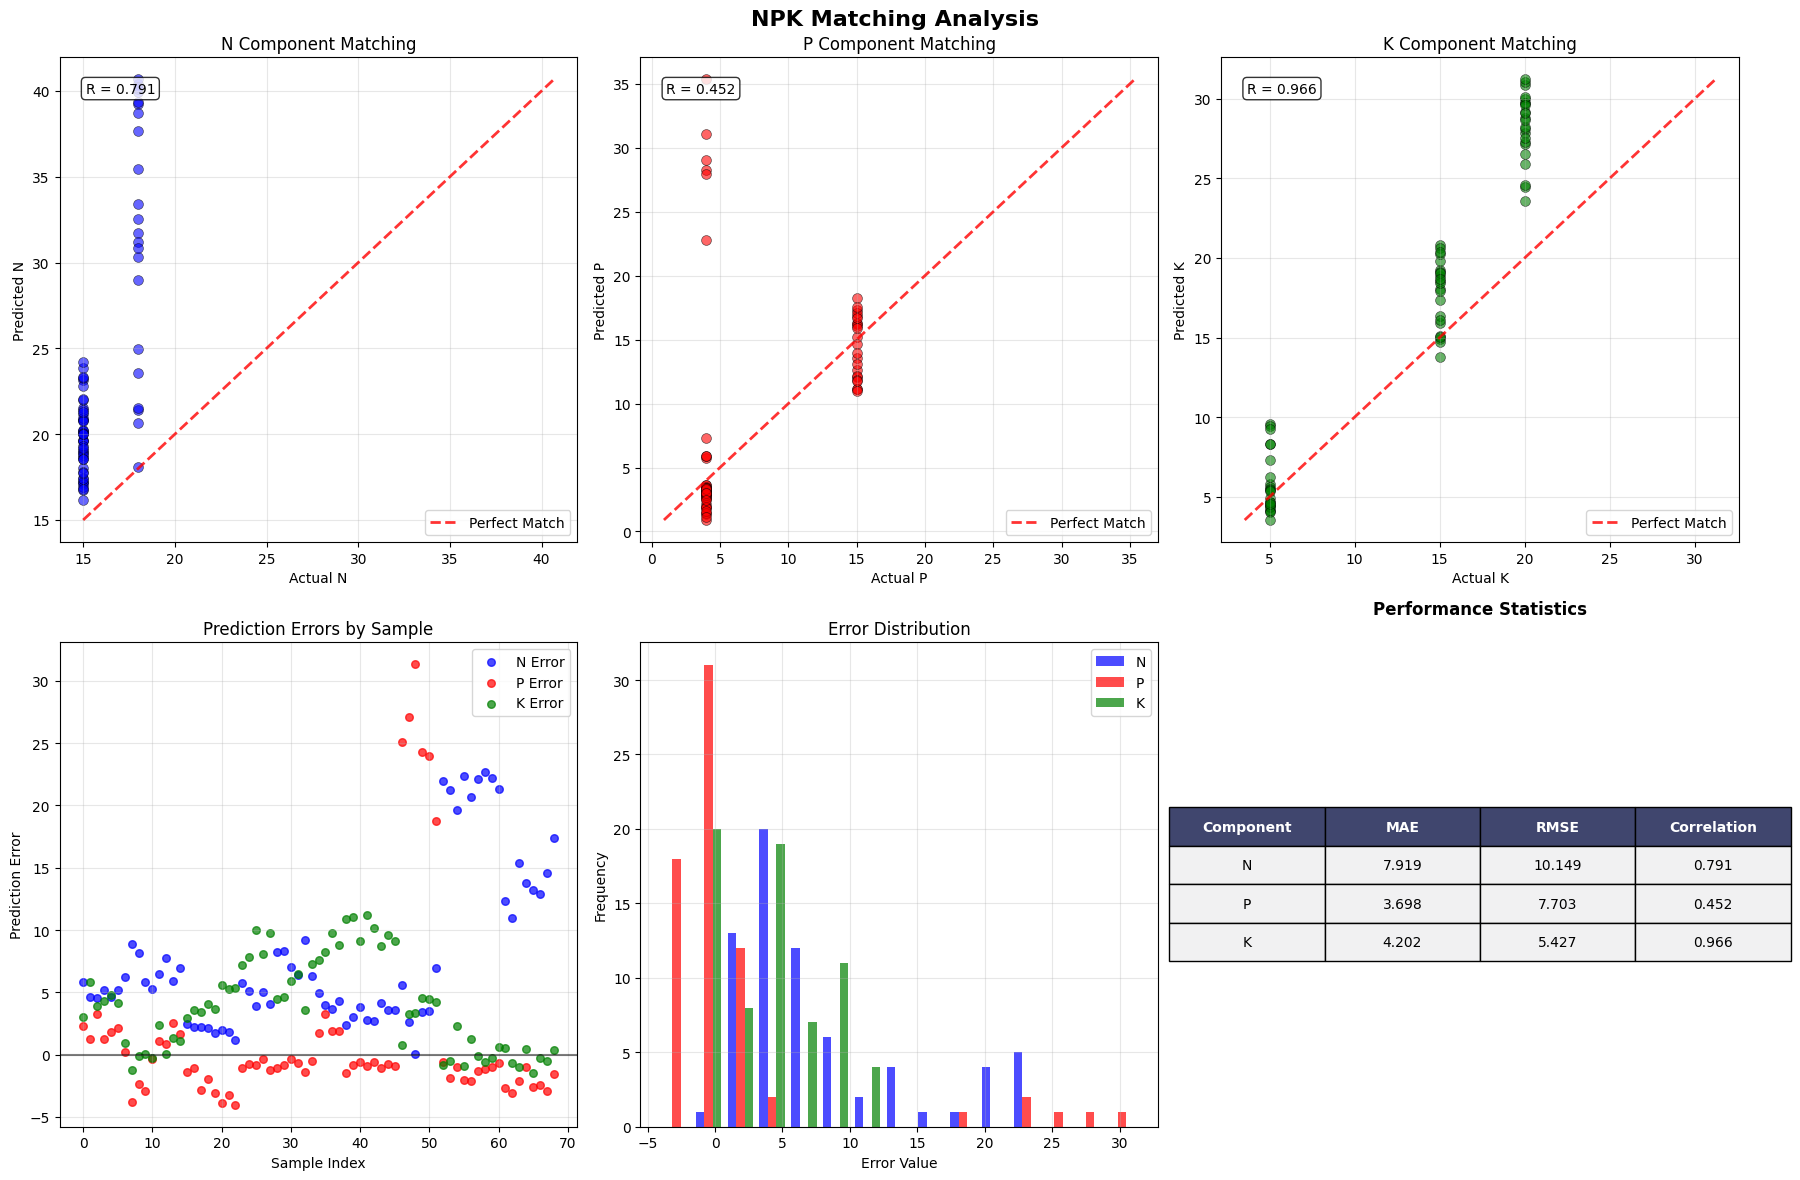


NPK MATCHING ANALYSIS SUMMARY

N Component:
  Mean Absolute Error: 7.919
  Root Mean Square Error: 10.149
  Correlation: 0.791
  Range - Actual: 15.0 to 18.0
  Range - Predicted: 16.182 to 40.673

P Component:
  Mean Absolute Error: 3.698
  Root Mean Square Error: 7.703
  Correlation: 0.452
  Range - Actual: 4.0 to 15.0
  Range - Predicted: 0.898 to 35.352

K Component:
  Mean Absolute Error: 4.202
  Root Mean Square Error: 5.427
  Correlation: 0.966
  Range - Actual: 5.0 to 20.0
  Range - Predicted: 3.539 to 31.222

Sample   Actual NPK      Predicted NPK        Error          
------------------------------------------------------------
1        [15 15 15]<15 [20.820462 17.296226 18.052209]<20 [5.820462 2.296226 3.052209]<15
2        [15 15 15]<15 [19.646769 16.273107 20.831254]<20 [4.646769 1.273107 5.831254]<15
3        [15 15 15]<15 [19.579141 18.264954 18.881254]<20 [4.579141 3.264954 3.881254]<15
4        [15 15 15]<15 [20.199564 16.254814 19.27593 ]<20 [5.199564 1.254814 4.2759

In [5]:

def get_npk(cluster_areas):
    """Get approximate NPK values based on cluster areas.
    
    Parameters:
        cluster_areas (list or array): [black, red, stain, white] areas
    """
    compositions = [
        {'N': 18, 'P': 46, 'K': 0},   # black
        {'N': 0, 'P': 0, 'K': 60},   # red
        {'N': 21, 'P': 0, 'K': 0},   # stain
        {'N': 46, 'P': 0, 'K': 0}   # white
    ]
    
    npk_total = {'N': 0, 'P': 0, 'K': 0}
    
    for i, area in enumerate(cluster_areas):
        for key in npk_total:
            npk_total[key] += compositions[i][key] * area
    
    total_beads = sum(cluster_areas)
    return [round(npk_total[key] / total_beads, 6) for key in ['N', 'P', 'K']]


# Prepare data for regression
X_area = cluster_areas_array # Data preparation for regression plotting
actual_npk = [  # map NPK values from folder names
    list(map(int, os.path.basename(os.path.dirname(path)).split('-')))
    for paths in img_path_list
    for path in paths
]

# get estimated data from cluster areas for regression
approx_npk = np.array([
    get_npk(areas) for areas in X_area
])

# ============== NPK MATCHING VISUALIZATION ==============
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Convert to numpy arrays for easier manipulation
actual_npk = np.array(actual_npk)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('NPK Matching Analysis', fontsize=16, fontweight='bold')

# 1. Scatter plots for each NPK component
components = ['N', 'P', 'K']
colors = ['blue', 'red', 'green']

for i, (component, color) in enumerate(zip(components, colors)):
    ax = axes[0, i]
    
    # Scatter plot
    ax.scatter(actual_npk[:, i], approx_npk[:, i], 
               alpha=0.6, color=color, s=50, edgecolors='black', linewidth=0.5)
    
    # Perfect match line
    min_val = min(np.min(actual_npk[:, i]), np.min(approx_npk[:, i]))
    max_val = max(np.max(actual_npk[:, i]), np.max(approx_npk[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Match')
    
    ax.set_xlabel(f'Actual {component}')
    ax.set_ylabel(f'Predicted {component}')
    ax.set_title(f'{component} Component Matching')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add correlation coefficient
    correlation = np.corrcoef(actual_npk[:, i], approx_npk[:, i])[0, 1]
    ax.text(0.05, 0.95, f'R = {correlation:.3f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top')

# 2. Error analysis
ax = axes[1, 0]
errors = approx_npk - actual_npk
for i, (component, color) in enumerate(zip(components, colors)):
    ax.scatter(range(len(errors)), errors[:, i], 
               label=f'{component} Error', alpha=0.7, color=color, s=30)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax.set_xlabel('Sample Index')
ax.set_ylabel('Prediction Error')
ax.set_title('Prediction Errors by Sample')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Error distribution
ax = axes[1, 1]
ax.hist([errors[:, i] for i in range(3)], bins=15, alpha=0.7, 
        label=components, color=colors)
ax.set_xlabel('Error Value')
ax.set_ylabel('Frequency')
ax.set_title('Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Summary statistics table
ax = axes[1, 2]
ax.axis('off')

# Calculate statistics
stats_data = []
for i, component in enumerate(components):
    mae = np.mean(np.abs(errors[:, i]))
    rmse = np.sqrt(np.mean(errors[:, i]**2))
    correlation = np.corrcoef(actual_npk[:, i], approx_npk[:, i])[0, 1]
    stats_data.append([component, f'{mae:.3f}', f'{rmse:.3f}', f'{correlation:.3f}'])

# Create table
table = ax.table(cellText=stats_data,
                colLabels=['Component', 'MAE', 'RMSE', 'Correlation'],
                cellLoc='center',
                loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Style the table
for i in range(len(components) + 1):
    for j in range(4):
        if i == 0:  # Header row
            table[(i, j)].set_facecolor('#40466e')
            table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            table[(i, j)].set_facecolor('#f1f1f2')

ax.set_title('Performance Statistics', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*50)
print("NPK MATCHING ANALYSIS SUMMARY")
print("="*50)

for i, component in enumerate(components):
    actual_vals = actual_npk[:, i]
    pred_vals = approx_npk[:, i]
    
    mae = np.mean(np.abs(pred_vals - actual_vals))
    rmse = np.sqrt(np.mean((pred_vals - actual_vals)**2))
    correlation = np.corrcoef(actual_vals, pred_vals)[0, 1]
    
    print(f"\n{component} Component:")
    print(f"  Mean Absolute Error: {mae:.3f}")
    print(f"  Root Mean Square Error: {rmse:.3f}")
    print(f"  Correlation: {correlation:.3f}")
    print(f"  Range - Actual: {np.min(actual_vals):.1f} to {np.max(actual_vals):.1f}")
    print(f"  Range - Predicted: {np.min(pred_vals):.3f} to {np.max(pred_vals):.3f}")

# Show sample-by-sample comparison
print(f"\n{'Sample':<8} {'Actual NPK':<15} {'Predicted NPK':<20} {'Error':<15}")
print("-" * 60)
for i in range(min(10, len(actual_npk))):  # Show first 10 samples
    actual = actual_npk[i]
    predicted = approx_npk[i]
    error = predicted - actual
    print(f"{i+1:<8} {actual}<15 {predicted}<20 {error}<15")

if len(actual_npk) > 10:
    print(f"... and {len(actual_npk) - 10} more samples")

In [6]:
print(f"Number of cluster area samples: {len(X_area)}")
print(f"Number of actual NPK samples: {len(actual_npk)}")

Number of cluster area samples: 69
Number of actual NPK samples: 69


In [13]:
for i in range(len(approx_npk)):
    print(approx_npk[i], actual_npk[i])

[20.820462 17.296226 18.052209] [15 15 15]
[19.646769 16.273107 20.831254] [15 15 15]
[19.579141 18.264954 18.881254] [15 15 15]
[20.199564 16.254814 19.27593 ] [15 15 15]
[19.622851 16.813644 19.786309] [15 15 15]
[20.21059  17.096321 19.134827] [15 15 15]
[21.187986 15.167504 15.91692 ] [15 15 15]
[23.876604 11.173304 13.788169] [15 15 15]
[23.144879 12.645366 14.911162] [15 15 15]
[20.821888 12.039483 15.072722] [15 15 15]
[20.265871 14.646073 14.743457] [15 15 15]
[21.500318 16.097301 17.354127] [15 15 15]
[22.788422 15.885686 15.064831] [15 15 15]
[20.927364 17.535709 16.362993] [15 15 15]
[21.963475 16.677817 16.098568] [15 15 15]
[17.446959 13.598543 17.923425] [15 15 15]
[17.212209 13.958475 18.573471] [15 15 15]
[17.215605 12.12339  18.422416] [15 15 15]
[17.118559 13.069529 19.079707] [15 15 15]
[16.760389 11.874899 18.654166] [15 15 15]
[16.933201 11.14919  20.613444] [15 15 15]
[16.789355 11.733693 20.236363] [15 15 15]
[16.182405 10.974271 20.380166] [15 15 15]
[20.75417  

In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import joblib

def tune_regressor(y_approx, y_true, save_path='checkpoints/regression_model.pkl', degree=2, alpha=1.0):
    """
    Train a polynomial linear regression model and save it as a checkpoint.

    Parameters:
        y_approx: Input features
        y_true: Target NPK values
        save_path: File path to save the trained model
        degree: Degree of the polynomial features
        alpha: Regularization strength for Ridge regression
    """
    # Create pipeline: Polynomial -> Ridge
    regressor = make_pipeline(
        PolynomialFeatures(degree=degree),
        Ridge(alpha=alpha)
    )

    # Train the model
    regressor.fit(y_approx, y_true)

    # Save model
    joblib.dump(regressor, save_path)
    print(f"Model checkpoint saved to: {save_path}")

    return regressor


def load_npk_regressor(model_path='checkpoints/regression_model.pkl'):
    """
    Load the saved regressor model from checkpoint.
    
    Parameters:
        model_path: Path to the saved model file
    
    Returns:
        regressor: Loaded LinearRegression model
    """
    try:
        regressor = joblib.load(model_path)
        print(f"Model loaded from: {model_path}")
        return regressor
    except FileNotFoundError:
        print(f"Model file not found at: {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model: {e}")
        return None


def predict_npk(regressor, cluster_areas):
    """
    Predict the actual NPK values based on a new cluster area input.

    Parameters:
        regressor (LinearRegression): Trained regression model
        cluster_areas (list or array): [white, stain, red, black] areas

    Returns:
        np.ndarray: Predicted NPK values as a NumPy array [N, P, K]
    """
    # Step 1: Convert cluster area to approximate NPK using same logic
    approx_npk = np.array(get_npk(cluster_areas)).reshape(1, -1)
    
    # Step 2: Predict using the trained regression model
    predicted_npk = regressor.predict(approx_npk)

    return predicted_npk.flatten()


# Example usage:
if __name__ == "__main__":
    # tune regressor
    regressor = tune_regressor(approx_npk, actual_npk, save_path='checkpoints/regression_model.pkl')

    # Loading the saved model
    loaded_regressor = load_npk_regressor('checkpoints/regression_model.pkl')
    
    # Example prediction with loaded model
    if loaded_regressor is not None:
        for i in range(len(approx_npk)):
            predicted_npk = regressor.predict(approx_npk[i].reshape(1, -1))
            print("Improved NPK prediction:", predicted_npk.flatten(), actual_npk[i])
    else:
        print("Could not make prediction - model not loaded successfully")




Model checkpoint saved to: checkpoints/regression_model.pkl
Model loaded from: checkpoints/regression_model.pkl
Improved NPK prediction: [15.1869516  14.02027396 14.51057203] [15 15 15]
Improved NPK prediction: [14.89885363 14.34804915 15.80207313] [15 15 15]
Improved NPK prediction: [15.11194047 14.74477554 14.55630878] [15 15 15]
Improved NPK prediction: [15.00614336 14.3128887  15.2816065 ] [15 15 15]
Improved NPK prediction: [14.9739422  14.63348753 15.29688555] [15 15 15]
Improved NPK prediction: [15.06577357 14.3174213  14.98139517] [15 15 15]
Improved NPK prediction: [15.24037192 13.94293161 14.27862604] [15 15 15]
Improved NPK prediction: [15.55473796 11.96744667 13.60474354] [15 15 15]
Improved NPK prediction: [15.39952235 12.60886504 14.0892678 ] [15 15 15]
Improved NPK prediction: [15.25730567 13.77226037 14.2715351 ] [15 15 15]
Improved NPK prediction: [15.24468716 14.40747653 14.04589305] [15 15 15]
Improved NPK prediction: [15.20657101 13.67963849 14.56730926] [15 15 15]


Model loaded from: checkpoints/regression_model.pkl


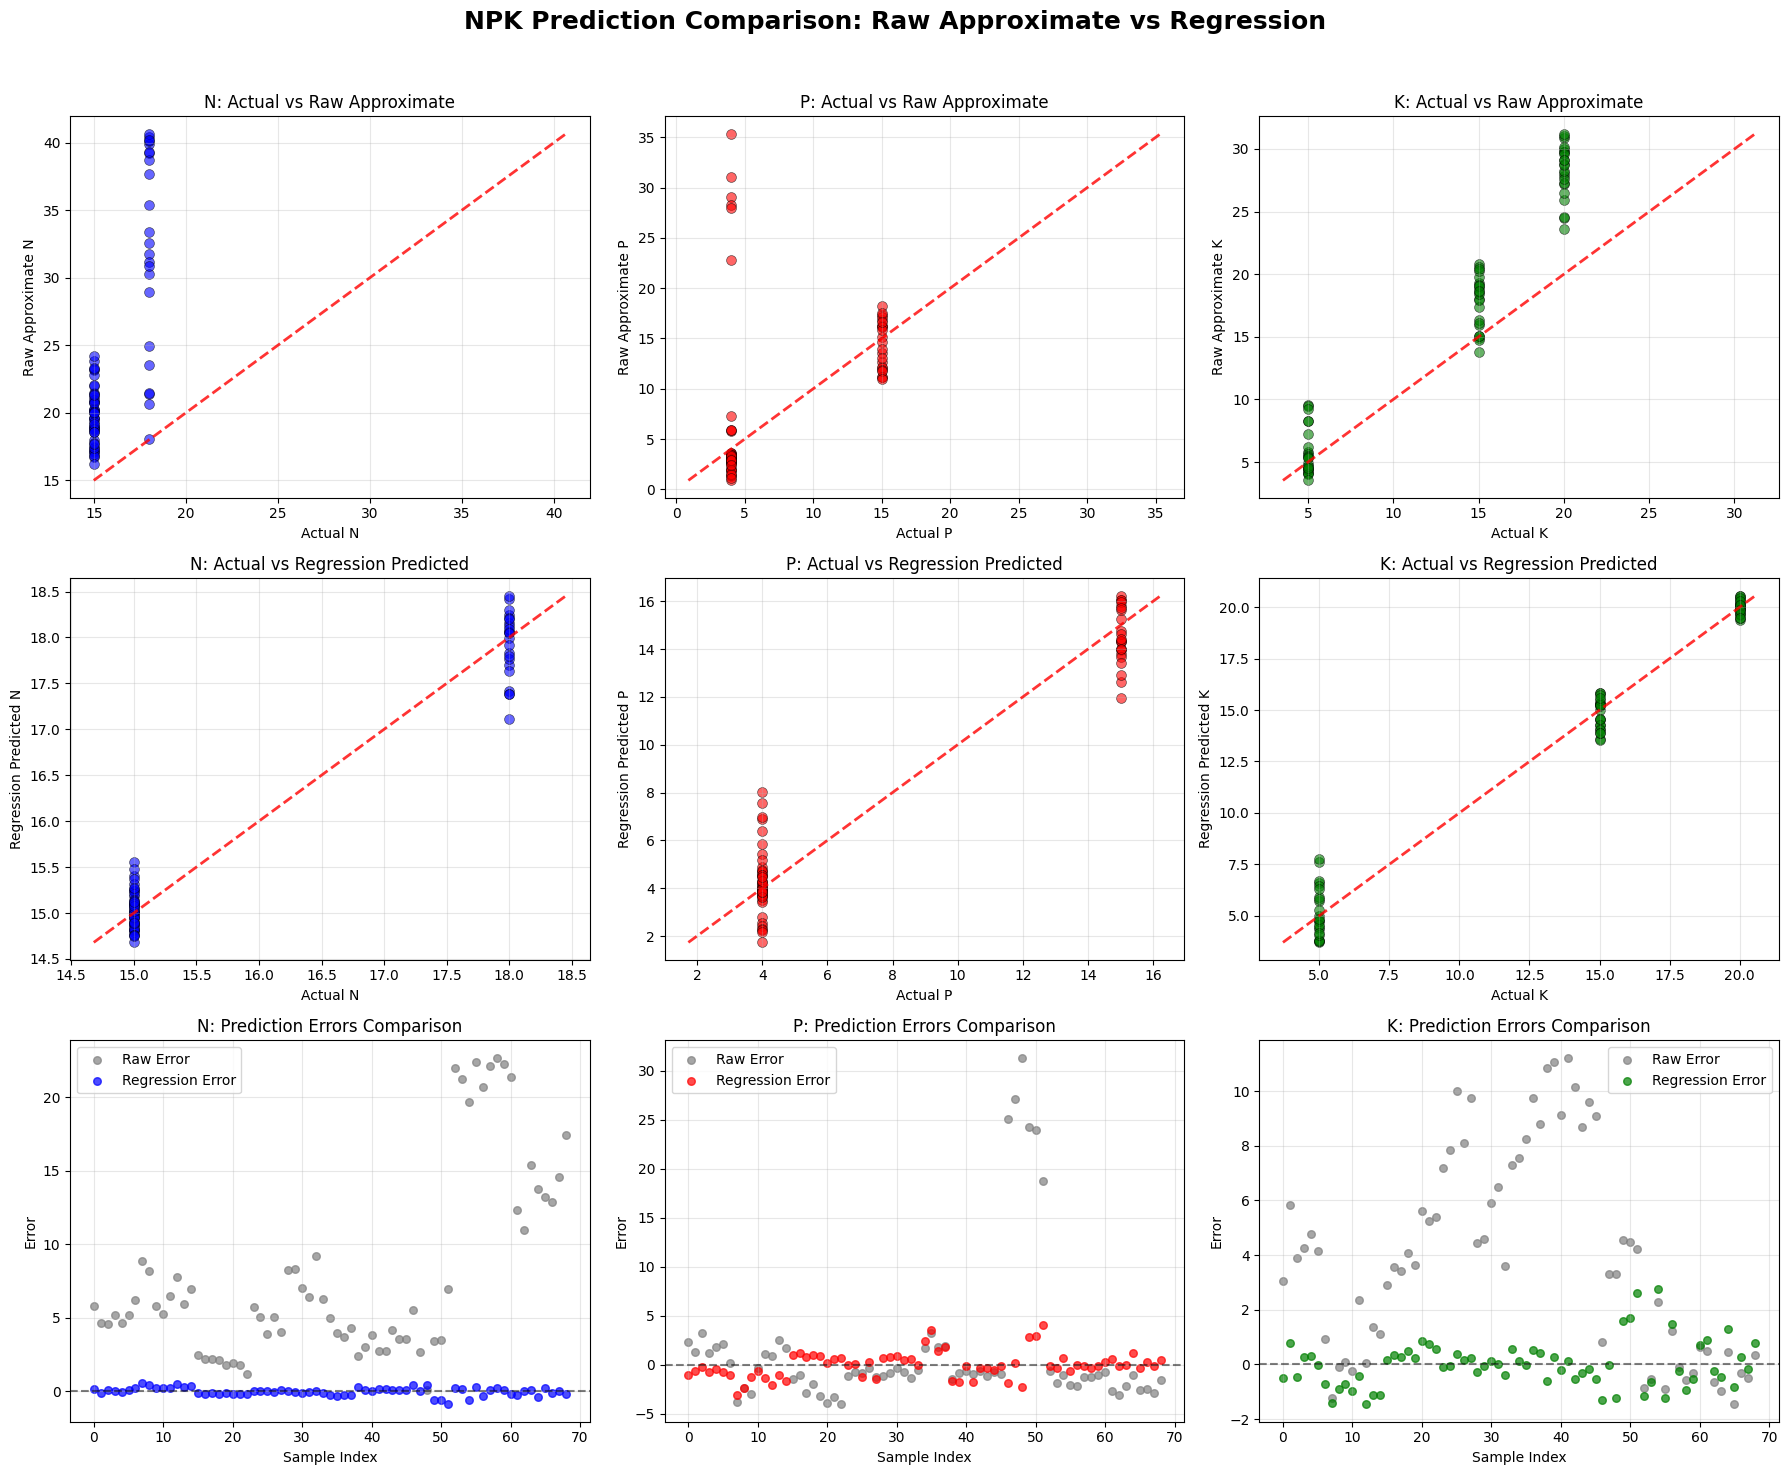

=== Error statistics comparison ===

Component: N
Raw Approximate MAE: 7.919, RMSE: 10.149
Regression Predicted MAE: 0.201, RMSE: 0.265

Component: P
Raw Approximate MAE: 3.698, RMSE: 7.703
Regression Predicted MAE: 0.964, RMSE: 1.321

Component: K
Raw Approximate MAE: 4.202, RMSE: 5.427
Regression Predicted MAE: 0.639, RMSE: 0.849


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables exist:
# y_actual_npk: np.array, shape (n_samples, 3)
# X_approx_npk: np.array, shape (n_samples, 3)
# regressor: trained sklearn LinearRegression model

# Predict improved NPK using the regression model
regressor = load_npk_regressor('checkpoints/regression_model.pkl')
X_predicted_npk = regressor.predict(approx_npk)  # shape (n_samples, 3)

components = ['N', 'P', 'K']
colors = ['blue', 'red', 'green']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('NPK Prediction Comparison: Raw Approximate vs Regression', fontsize=18, fontweight='bold')

for i, component in enumerate(components):
    # --- 1. Actual vs Raw Approximate ---
    ax = axes[0, i]
    ax.scatter(actual_npk[:, i], approx_npk[:, i], 
               alpha=0.6, color=colors[i], s=50, edgecolors='black', linewidth=0.5)
    min_val = min(np.min(actual_npk[:, i]), np.min(approx_npk[:, i]))
    max_val = max(np.max(actual_npk[:, i]), np.max(approx_npk[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    ax.set_xlabel(f'Actual {component}')
    ax.set_ylabel(f'Raw Approximate {component}')
    ax.set_title(f'{component}: Actual vs Raw Approximate')
    ax.grid(True, alpha=0.3)

    # --- 2. Actual vs Regression Predicted ---
    ax = axes[1, i]
    ax.scatter(actual_npk[:, i], X_predicted_npk[:, i], 
               alpha=0.6, color=colors[i], s=50, edgecolors='black', linewidth=0.5)
    min_val = min(np.min(actual_npk[:, i]), np.min(X_predicted_npk[:, i]))
    max_val = max(np.max(actual_npk[:, i]), np.max(X_predicted_npk[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    ax.set_xlabel(f'Actual {component}')
    ax.set_ylabel(f'Regression Predicted {component}')
    ax.set_title(f'{component}: Actual vs Regression Predicted')
    ax.grid(True, alpha=0.3)

    # --- 3. Error Comparison (Raw vs Regression) ---
    ax = axes[2, i]
    raw_errors = approx_npk[:, i] - actual_npk[:, i]
    reg_errors = X_predicted_npk[:, i] - actual_npk[:, i]
    ax.scatter(range(len(raw_errors)), raw_errors, label='Raw Error', alpha=0.7, color='gray', s=30)
    ax.scatter(range(len(reg_errors)), reg_errors, label='Regression Error', alpha=0.7, color=colors[i], s=30)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Error')
    ax.set_title(f'{component}: Prediction Errors Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Print summary stats for raw and regression ---

def print_stats(errors, label):
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    print(f"{label} MAE: {mae:.3f}, RMSE: {rmse:.3f}")

print("=== Error statistics comparison ===")
for i, component in enumerate(components):
    print(f"\nComponent: {component}")
    raw_errors = approx_npk[:, i] - actual_npk[:, i]
    reg_errors = X_predicted_npk[:, i] - actual_npk[:, i]
    print_stats(raw_errors, "Raw Approximate")
    print_stats(reg_errors, "Regression Predicted")
